## Setup

Install dependencies and ensure that Python version >= 3.10. Restart the Kernel if needed.

In [2]:
%pip install requirements

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement requirements (from versions: none)
ERROR: No matching distribution found for requirements
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
import os

import pandas as pd
import json
import glob

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sys.path.append('..')
import codex as codex
import src.output as output
from tutorial_materials.build import tutorial_functions

/home/hume-users/leebri2n/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


2.3.0+cu121
0.18.0+cu121


## A) Dataset Split Evaluation
**Dataset split evaluation computes the set difference combinatorial coverage ($SDCC_t$) between provided datasets for a specified strength $t$ and a defined universe.** Recall that SDCC is the proportion of the t-way interactions in a target dataset $T$ that do not appear in a source dataset $S$. This can be expressed as $T-S$, or $T \backslash S$.

$$
SDCC_t(T\backslash  S) = \frac{|T_t\backslash S_t|}{|T_t|}
$$

SDCC measures a difference between the datasets as a type of distance. SDCC values closer to 1 indicates dissimilarity, while those closer to 0 indicates the sets are more similar in the interactions they contain for a particular level of $t$.

Consider this example abstract dataset containing feature columns "A", "B", "C", "D" as well as a unique sample ID column and label column(s). Multiple strengths can be provided in one input file to obtain a set of $SDCC_t$ outputs as well as $CC_t$ outputs. 

#### Input file

The input file defines all the necessary components for the experiment configuration.

In [4]:
with open('tutorial_materials/input/demo_input-dataset_split_evaluation.json') as f:
    codex_input = json.load(f)
    output_path, strengths = codex.input_parser.define_experiment_variables(codex_input)

display(codex_input)

{'mode': 'dataset split evaluation',
 'codex_directory': './',
 'config_id': '__DEMO-dataset_split_evaluation_results',
 'dataset_name': 'Abstract',
 'model_name': '',
 'data_directory': 'tutorial_materials/datasets_tabular/',
 'dataset_file': 'abstract_skew.csv',
 'features': ['A', 'B', 'C', 'D'],
 'bin_file': 'tutorial_materials/binning/bins-abstract-disc.txt',
 'sample_id_column': 'id',
 'universe': None,
 'use_augmented_universe': False,
 'counting_mode': 'label_exclusive',
 't': [1, 2, 3],
 'split_folder': 'tutorial_materials/splits/abstract_split',
 'split_file': 'split_00.json',
 'performance_folder': 'tutorial_materials/performance/abstract_perf',
 'performance_file': 'performance_00.json',
 'metric': 'accuracy',
 'sdcc_direction': 'train-test',
 'timed_output': False}

#### Split file
In many conventional cases, samples are split randomly with arbitrary sizes given to the training, validation, and test sets. Without the proper algorithms in place, random splits are often the easiest method to implement. However, the there is no guarantee that the resulting subsets of data are balanced, especially for the higher t-way interactions interactions.

The dataset split evaluation mode can be used as a way to identify and measure these imbalances in the data beyond the $t=1$ feature levels.

In [ ]:
split_file_path = os.path.join(codex_input['split_folder'], codex_input['split_file'])
with open(split_file_path) as f:
    split = json.load(f)

print("Training samples keyed under 'train' ({}):".format(len(split['train'])), split['train'])
print("Validation samples keyed under 'validation' ({}):".format(len(split['validation'])), split['validation'])
print("Testing samples keyed under 'test' ({}):".format(len(split['test'])), split['test'])

Training samples keyed under 'train' (650): ['193', '594', '245', '675', '284', '278', '654', '810', '887', '100', '767', '588', '337', '613', '786', '206', '486', '241', '504', '649', '161', '705', '983', '98', '1', '988', '639', '148', '547', '459', '407', '782', '950', '641', '316', '989', '914', '321', '759', '896', '955', '5', '829', '599', '77', '640', '944', '536', '311', '15', '168', '366', '159', '365', '967', '170', '463', '103', '928', '261', '394', '951', '96', '945', '347', '306', '540', '748', '632', '48', '570', '464', '575', '605', '214', '503', '518', '419', '584', '399', '913', '745', '212', '987', '543', '841', '587', '957', '554', '56', '607', '130', '509', '606', '479', '744', '964', '287', '702', '115', '827', '122', '330', '971', '333', '21', '220', '271', '846', '37', '188', '447', '396', '99', '23', '941', '858', '401', '819', '656', '458', '721', '2', '152', '785', '648', '651', '368', '263', '276', '249', '968', '250', '69', '11', '182', '474', '886', '784', 

#### Universe

In [5]:
dataset_path_abstract = os.path.join(codex_input['data_directory'], codex_input['dataset_file'])
df_abstract = pd.read_csv(dataset_path_abstract)
print("DATASET, LOCATED AT:", dataset_path_abstract)
display(df_abstract.head())

binning_path_abstract = os.path.join(codex_input['bin_file'])
print("BINNING SCHEME FILE, LOCATED AT:", binning_path_abstract)
with open(binning_path_abstract) as f: print(f.read())

print("\nSTRENGTHS:")
print("t =",strengths)

DATASET, LOCATED AT: tutorial_materials/datasets_tabular/abstract_skew.csv


,Unnamed: 0,id,A,B,C,D,lab
0,0,0,a1,b1,c2,d3,l2
1,1,1,a1,b1,c1,d3,l2
2,2,2,a1,b1,c1,d3,l3
3,3,3,a1,b1,c3,d1,l2
4,4,4,a1,b2,c1,d2,l1


BINNING SCHEME FILE, LOCATED AT: tutorial_materials/binning/bins-abstract-disc.txt
A: a1;a2
B: b1;b2
C: c1;c2;c3
D: d1;d2;d3;d4

STRENGTHS:
t = [1, 2, 3]


With no provided universe file located in the input file, CODEX constructs a universe that describes the input space using at least the dataset and supplemented by the binning file. Below is universe constructed by CODEX.

In [5]:
universe, dataset, features = codex.codex_universe.define_input_space(codex_input)
display(universe)

{'features': ['A', 'B', 'C', 'D'],
 'levels': [['a1', 'a2'],
  ['b1', 'b2'],
  ['c1', 'c2', 'c3'],
  ['d1', 'd2', 'd3', 'd4']]}

### Experiment run

With a dataset, values of $t$, a defined universe, and at least a split file, dataset split evaluation can be run. 

In [6]:
codex_input_eval = codex_input
eval_results_abstract = codex.run(codex_input_eval, subset='')

### Experiment results

Results of the dataset split evaluation experiment is stored in a dictionary. Among these are:
- Number of appearing interactions vs. number of intercations possible
- Computed CC values for **splits of data** and SDCC values of **set differences between splits of data**
- Feature combination names, feature interaction counts
- Missing interactions for each value of $t$.

In [7]:
print("RESULTS: SDCC VALUES")
for t in strengths:
    print("Proportion of interactions in test set not appearing in training set, t={}:".format(t), "%.3f"%eval_results_abstract[t]['test-train']['SDCC'])

print('\nRESULTS: RANKS')
for t in strengths:
    print("t={} Feature combinations:".format(t), eval_results_abstract[t]['val']['ranks'])

print('\nRESULTS: INTERACTION COUNTS')
for t in strengths:
    print("t={} Interaction counts in training set:".format(t), eval_results_abstract[t]['train']['combination counts'])
    print("t={} Interaction counts in test \ train set difference:".format(t), eval_results_abstract[t]['test-train']['sdcc counts'], '\n')

print('\nRESULTS: MISSING INTERACTIONS')
for t in strengths:
    print("t={} Missing interactions in test set:".format(t), eval_results_abstract[t]['test']['missing interactions'])

RESULTS: SDCC VALUES
Proportion of interactions in test set not appearing in training set, t=1: 0.000
Proportion of interactions in test set not appearing in training set, t=2: 0.000
Proportion of interactions in test set not appearing in training set, t=3: 0.028

RESULTS: RANKS
t=1 Feature combinations: ['A', 'B', 'C', 'D']
t=2 Feature combinations: ['A*B', 'A*C', 'B*C', 'A*D', 'B*D', 'C*D']
t=3 Feature combinations: ['A*B*C', 'A*B*D', 'A*C*D', 'B*C*D']

RESULTS: INTERACTION COUNTS
t=1 Interaction counts in training set: [[596, 54], [471, 179], [292, 233, 125], [317, 168, 79, 86]]
t=1 Interaction counts in test \ train set difference: [[0, 0], [0, 0], [0, 0, 0], [0, 0, 0, 0]] 

t=2 Interaction counts in training set: [[436, 35, 160, 19], [262, 30, 218, 15, 116, 9], [214, 78, 159, 74, 98, 27], [290, 27, 156, 12, 74, 5, 76, 10], [234, 83, 120, 48, 57, 22, 60, 26], [141, 119, 57, 76, 52, 40, 41, 27, 11, 34, 35, 17]]
t=2 Interaction counts in test \ train set difference: [[0, 0, 0, 0], [0

For the t=1 result, every set difference direction value at the t=1 is zero. That is, all feature levels for each feature that appear in training set appear in test.

For a result like the t=3 comparison train-test indicates that around 2.8% of 3-way interactions appearing in the testing set do not appear in the training set. In other words, the training set does nto cover 2.8% of the possible test cases of 3-way interactions.

### Experiment results: Visualizations

##### 1) SDCC heatmaps
Computing SDCC between splits of the dataset provides for additional analysis by examining the set difference version of the combinatorial heatmap.

Observe examples of the test-train case for this experiment. 

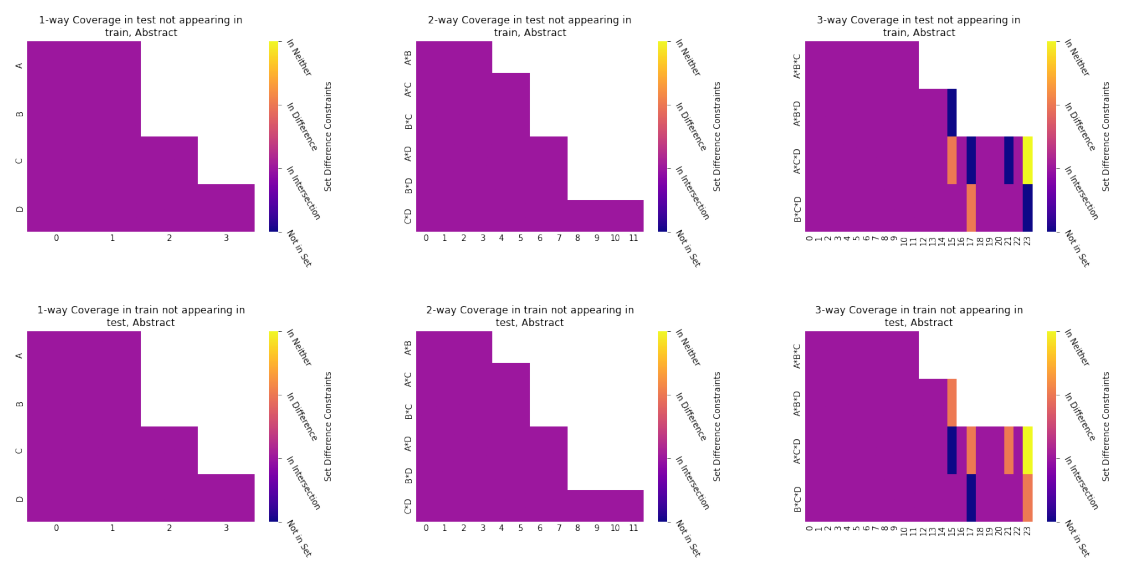

In [8]:
fig, ax = plt.subplots(2,3, figsize=(20,16))
fig.subplots_adjust(wspace=0.15, hspace=-0.5)

for i in range(len(ax)):
    for j in range(len(ax[0])):
        ax[i][j].axis('off')

for t in strengths:
    img_t = mpimg.imread(os.path.join(output_path, 'SDCC', 'SDCC-t{}-way Set Diff test not appearing in train_Abstract_wneither.png'.format(t)))
    img_t_op = mpimg.imread(os.path.join(output_path, 'SDCC', 'SDCC-t{}-way Set Diff train not appearing in test_Abstract_wneither.png'.format(t)))
    ax[0][t-1].imshow(img_t)
    ax[1][t-1].imshow(img_t_op)
    ax[0].axis('off')
    ax[1].axis('off')

The maps reflect the computed numerical results. At the $t=1$ and $t=2$ levels, there is no interaction in test that does not appear in train. The training set covers the all test cases at least once at the feature level and combinations of two features. 

At the $t=3$ level, the test set is missing 4 interactions as indicated by the dark indigo, two unseen interactions present that are not present in the training set, as indicated by the orange, and one interaction that does not appear in either set, as indicated by the yellow. The intersecting interactions that appear are colored with purple.


##### 2) Set difference direction SDCC chart
In addition to the new set difference heatmaps, dataset split evaluation provides a bar chart of each direction's SDCC value to view the magnitude of differences as a distance between the set for each value of $t$ to visualize overall similarity.

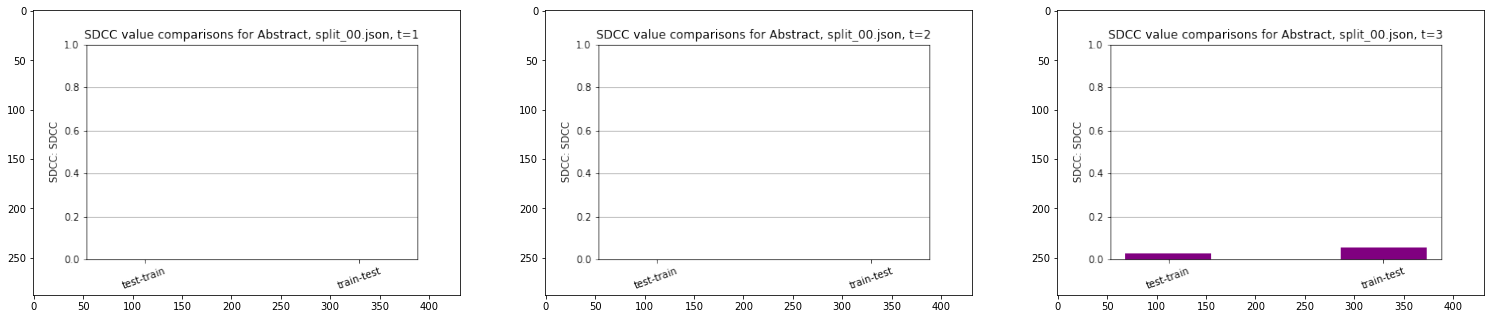

In [9]:
fig, ax = plt.subplots(1,3, figsize=(26, 20))

for t in strengths:
    img_t = mpimg.imread(os.path.join(output_path, 'dataset_split_eval_split_00.jsont{}.png'.format(t)))
    ax[t-1].imshow(img_t)

In this example, the charts reflect the computed numerical result. In the test-train direction for $t=3$, 2.8% of interactions in the test set do not appear in the test set, and that level is less than 5% in the chart.

To get a better idea of these differences, we can examine two sets. One whose splits are the exact same samples and therefore are guaranteed to have the exact same set difference, and one whose splits are exact opposites, increasing the likelihood of interactions that appear in one split that do not in the other. *revisit*

In [6]:
# Insert example + counterexample

## B) Dataset Split Comparison

Because machine learning models often train and test from the same dataset, how the splits are constructed is a likely factor of machine learning model performance.

Through dataset split comparison, recorded model performance can be leveraged alongside dataset split evaluation to identify a correlation between SDCC values between a subsets of a dataset split and model performance operating on that split.

----
### Splits and Performance
As mentioned, random splits of a dataset often fail to consider data beyond the feature level. *Previous findings show these imbalances in combinatorial coverage between subsets matter.* Intuitively, test sets that are representative of a corresponding training set can be used to assess the model's training ability, while test sets that are nonrepresentative of the training set can be used to assess model robustness under different operating conditions. 

Therefore, exploring the discrepancies between splits is worthwhile, as ideally, model performance is measured confidently when the testing pool reflects the training pool and generalizability is explored when the testing pool differs from the training pool. These are considerations that CODEX aims to assist in for those designing data splitting algorithms.

Dataset split evaluation can be leveraged to run with one or more performance files resultant of their corresponding pslits through *dataset split comparison*. SDCC is comptuted between sets of data or between splits and compared against the resultant model performance on the test sets to explore any correlation that might exist between dataset distance and model training/testing ability.

----

### Rareplanes Example
Consider the RarePlanes dataset, an open source dataset consisting of real and synthetic satellite imagery capturing regions with aircraft on the ground. Of the real dataset, 253 satellite images distributed among 8,525 image tiles. Provided tabular metadata is included, and this is a case in which CODEX can be used to explore a dataset that itself is not tabular in its original form.

Below is one such sample and its associated metadata.


In [ ]:
# Rareplanes

rareplanes_df = pd.read_csv(os.path.join('tutorial_materials', 'datasets_tabular', 'RarePlanes_Metadata_Augmented_Processed_localized-tiled-controlpt.csv')).drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
rareplanes_df.index = rareplanes_df.image_tile_id

display(rareplanes_df.loc['98_104001000F15D300_tile_177'])
display(rareplanes_df[rareplanes_df.index == '98_104001000F15D300_tile_177'])

img = Image.open(os.path.join('..', 'assets', '98_104001000F15D300_tile_177.png'))
display(img)


### Using dataset split comparison to evaluate a splitting algorithm 

In this example, we will consider the split, _2_2_, with the first digit indicating the index of the feature or combination being excluded and th second digit indicating the index of the level of the t-way interaction being excluded. In this case where $t=1$, _2_2_ constructs splits whose test sets include and exclude the third level of the third feature.

With these splits, a model trains on a set with no samples with the withheld t-way interaction being used in training or validation while evaluating on sets exclusively containing samples wiht the interaction. Here, dataset split comparison explores a possible correlation between the presence or absence of the interaction in the training data and changes in model performance.

With a dataset, a specified t, a defined universe, one or more split files and corresponding performance files, dataset split comparison can be run.

In the case of multiple split files, the filenames are passed in as a list in the 'split_file' and 'performance_file' keys of the input file, respectively, rather than just a single string.

In [13]:
with open(os.path.join('tutorial_materials', 'input', 'demo_input-dataset_split_comparison.json')) as f:
    input_comparison = json.load(f)
    input_comparison['split_file'] = ['model_2_2_all.json', 'model_2_2_incl.json', 'model_2_2_excl.json', 'model_x_all.json']
    input_comparison['performance_file'] = ['performance_2_2_all.json', 'performance_2_2_incl.json', 'performance_2_2_excl.json', 'performance_x_all.json']
    output_path, strength = codex.input_parser.define_experiment_variables(input_comparison)

codex.run(input_comparison)

/home/hume-users/leebri2n/PROJECTS/ai-th/CODEX/__tutorials/../lib/plotting_mpl.py:106: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


{'model_2_2_all.json': {'split_id': 'model_2_2_all.json',
  'universe': {'features': ['Hour_of_Day',
    'off_nadir_max',
    'avg_pan_resolution',
    'Season',
    'biome',
    'CONTROL'],
   'levels': [['[10.26,11.27)',
     '[11.27,12.28)',
     '[12.28,13.29)',
     '[13.29,14.3)',
     '[14.3,15.32]'],
    ['[3,12]', '(12,21]', '(21,30]'],
    ['(0.31,0.3419495)', '[0.3419495,0.3729495]', '(0.3729495,0.41]'],
    ['Spring', 'Summer', 'Autumn', 'Winter'],
    ['Temperate Grasslands, Savannas & Shrublands',
     'Temperate Broadleaf & Mixed Forests',
     'Temperate Conifer Forests',
     'Boreal Forests/Taiga',
     'Flooded Grasslands & Savannas',
     'Deserts & Xeric Shrublands',
     'Mediterranean Forests, Woodlands & Scrub',
     'Mangroves',
     'Tropical & Subtropical Moist Broadleaf Forests',
     'Tropical & Subtropical Coniferous Forests',
     'Tropical & Subtropical Grasslands, Savannas & Shrublands',
     'Tundra'],
    ['1', '2', '3']]},
  1: {'train': {'count appe

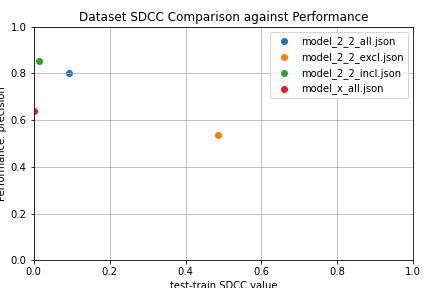

In [14]:
img = Image.open(os.path.join(output_path, 'test-train-dataset_split_comparison_2.png'))
display(img)

### Interpretation of results:

Because the excluded test set was formed with samples containing an interaction specifically withheld from the training training set, we expect the included test set to be much more similar to the trianing set than the excluded set by design. This is reflected in the SDCC values, where test_excluded-train has a higher SDCC value than that of test_included-train. Evaluating the model on precision over the both sets, there is over a 25% drop in performance. In other words, the model degrades in performance when deployed outside of its operating envelope. Similar behavior observed in other such splits of this rareplanes dataset suggests there might exist a correlation between data split differences and resultant model performance. 

In addition to this exploration of SDCC-performance correlation, the utilization of dataset split evaluation functionality allows the user to identify the absence of certain interactions and therefore provides a target for the creation algorithims that construct balanced and interesting test sets for model test and evaluation.

(REVISE/REMOVE BELOW)
Because samples were excluded on the basis of t=1 way interactions in the data, this means that at other levels of t, the can't say that the test set not covered by training is completely covered because samples even containing the excluded interaction are withheld from the test set. That is, to say that these modes do not prove or even show a direct causation that greater differences cause better performances.
